# Citation
#### Baevski, A., Zhou, H., Mohamed, A., & Auli, M. (2020). wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations. Advances in Neural Information Processing Systems (NeurIPS) 33. https://arxiv.org/abs/2006.11477
#### This explanation is a personal walkthrough of the paper wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations. All credit for the original research goes to the authors listed above.
**Image Attribution**

#### Unless otherwise noted, all figures and content explained here are either original or sourced from Baevski et al., 2020 — wav2vec 2.0: A Framework for Self-Supervised Learning of Speech Representations.

# Prerequisites:
#### Gumbel Softmax, CTC

# Introduction
#### Wav2vec2 is build on top of Wav2Vec and Vq-Wav2Vec. Since, these models are discussed in detail, we can understand the workings of wav2vec2 very easily.
#### Let's see the architecure

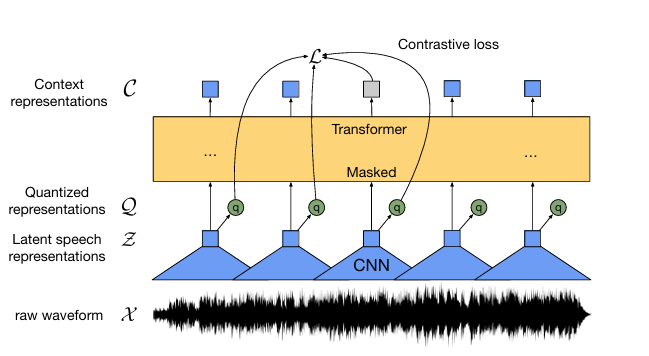

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Images/wav2vec2.png')

#### There are three main components working sequentially
# 1) Feature Encoder (f): 
#### The Raw Audio (X) is transformed to latent speech representations (Z)
#### f is defined as f:X->Z
#### The encoder consists of several blocks containing a temporal convolution followed by layer normalization and a GELU activation function.

# 2) Contextualized representations with Transformers: 
#### The latent speech representations (Z) from the feature encoder are fed into a Transformer network composed of multiple self-attention layers. Rather than using fixed positional embeddings, this network utilizes a convolutional layer to learn relative positional embeddings, which are added to inputs after a GELU activation and layer normalization. This design allows the model to build contextualized representations capturing dependencies across the entire audio sequence effectively.

# 3) Quantization Module: 
#### The latent speech representations is transformed into discrete units using product quantization. Product quantization chooses quantized representations from multiple codebooks and concatenates them. Gumbel Softmax is used to choose a codebook in a differentiable way. Straight-through estimator is used to allow gradients to pass through and hence learn.

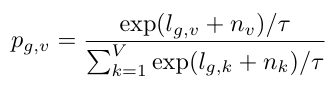

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Images/gumbel softmax.png')

# Training

## i) Masking
#### Just like BERT's Masked Language Model, certain timesteps of the latent feature representations (Z) are masked so that the model learns to identify the correct quantized latent representations (Q). Out of all the time steps, a sample of a certain proportion p is chosen to represent the starting indices and then mask the subsequent M consecutive timesteps from every sampled index. We do not mask the raw audio input (X). All the masked positions are replaced with a single shared trainable feature vector.
#### The quantization module receives the latent representations (Z) while the transformer receives the masked features.
#### For example, if M = 10 and each time step = 10ms, then the model represents 100ms of audio.

## ii) Objective
#### During pre-training, spans of the latent audio representations are masked before input to the Transformer. The model learns to identify the correct quantized representation for the masked span among a set of distractors using a contrastive loss. This joint training of discrete units and contextual representations facilitates learning robust speech features.

#### After pre-training, the model is fine-tuned on labeled data for speech recognition, usually using the Connectionist Temporal Classification (CTC) loss, enabling strong performance even with limited labeled examples.

## a) Contrastive Loss (L_m)
#### This is used to teach the model to distinguish between the correct quantized representation for each masked time step from a given set of distractors.
#### To acheive this, similiarity between the context vector and the true quantized vector. 

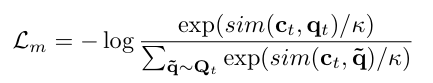

In [3]:
%matplotlib inline
from IPython.display import Image
Image('Images/Contrastive Loss.png')

#### In the above formula, sim(.) is the similarity where it is calculated by cosine similarity. 
#### c_t is the context vector, it is the quantized representation the model predicted.
#### q_t is the actual or true quantized representation.
#### q_cap is sampled from Q_t (the set of quantized representations), it acts as negative samples or the false quantized representations.
#### Each term is divided by k, which is the temperature. Low k means the softmax will give sharp distributions. High k makes the softmax give a uniform distribution. We would like to have a sharp distribution so that the model will correctly learn the correct representations.
#### Each of these terms is further used as input to the exponential function, exp(.). A small change in the value results in huge increase or decrease in the exp(.) term. It also makes the output positive
#### Negative log, -log(x), it is small when x is close to 1 (the model is correct) and it is large x is close to 0 (the model is incorrect).

## b) Diversity Loss (L_d)
#### This is used to make sure that the model does not choose only a few set of codebooks to predict quantized representations.
#### The lower the diversity loss, the more chance the model will learn every codebook equally.

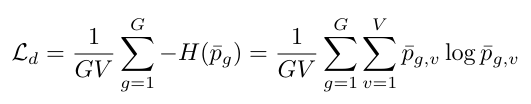

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Images/Diversity Loss.png')

#### p_bar(g, v) is the average proabability that group g and codebook v is chosen during quantization.
#### Entropy, H(x), is used to find the measure of uncertainty. It does so by using the formula H(x) = - Summation_from_x=1_to_n xlog(x).
#### log(x) is big when x is small and small when x is big. This signifies that for events (x) which occur rarely, which means x is small, the entropy or the 'surprise' is big and vice-versa.

#### x is multiplied with log(x) because it weighs the surprise by how often it happens.
#### G is the number of groups and V is the number of codebooks in each group.
#### Entropy is divided by GV to normalize the diversity loss to average per group per codeword.

## c) Total Loss (L)
#### It is the sum of Contrastive loss and diversity loss. A tuned hyperparameter (aplha) is used to make sure that the diversity loss term doesn't go too large to dominate the total loss or too small to be neglected by the total loss.

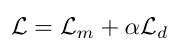

In [2]:
%matplotlib inline
from IPython.display import Image
Image('Images/Total Loss.png')

## iii) Fine-tuning
#### The pre-trained model is fine-tuned for speech recognition by adding a randomly initiated linear projection on top of the context network into C classes representing the vocabulary of the words. 
#### For example, Librispeech dataset consists of 29 tokens and 1 extra token called word boundary token.
#### The 29 tokens includes English alphabets (A-Z), extra tokens (like space, comma, etc)
#### Word boundary token is used to indicate the word ending.

#### Example calculation: Assume context network outputs vectors of size 768 (feature dimension)
#### Vocabulary (C) size is 30 (29 tokens + 1 word boundary token) for Librispeech dataset.
#### Hence, the linear projection layer maps from a 768-dimensional vector to a 30-dimensional vector.
#### For each timestep (t), the context vector (size 768) is multiplied with the weight matrix (size 768*30), producing a 30-dimensional logit vector. This represents the scores or the probability of each token.



#### The model is optimized by minimizing CTC loss (Connectionist Temporal Classification loss). To generalize the model, SpecAugment is used to randomly masks (hides) portions of the audio features along time and feature channels during training.  

# Conclusion
#### Wav2Vec2 has 3 main components: A convolutional feature encoder that transforms raw audio into latent speech representations, a quantization module that discretizes these representations into a fixed set of speech units, and a context network (Transformer) that processes the masked features to generate context-rich, contextualized representations
#### During training, the model masks some parts of the latent features, and the Transformer learns to predict the correct masked units by comparing its output with the quantized representations using a contrastive loss.
#### The input to the wav2vec2 is a raw audio waveform and output is a context-aware speech representations suitable for downstream tasks such as speech recognition.